In [1]:
from iSORTlib import *
seed_everything(20)

# Tutorial for reconstructing spatial organzation using multiple slices

## 1. Load data

### Set directories

In [2]:
sc_data_dir = '151674_data.csv'
sc_meta_dir = '151674_meta.csv'

st_data_1_dir = '151675_data.csv'
st_meta_1_dir = '151675_meta.csv'
st_data_2_dir = '151507_data.csv'
st_meta_2_dir = '151507_meta.csv'
st_data_3_dir = '151508_data.csv'
st_meta_3_dir = '151508_meta.csv'

### Read and preprocess scRNA-seq and multiple ST datasets, then identify common highly variable genes

In [3]:
sc_adata = preprocess.read_data(sc_data_dir, sc_meta_dir, 'sc')

st_151675_adata = preprocess.read_data(st_data_1_dir, st_meta_1_dir, 'st')
st_151507_adata = preprocess.read_data(st_data_2_dir, st_meta_2_dir, 'st')
st_151508_adata = preprocess.read_data(st_data_3_dir, st_meta_3_dir, 'st')

common_hvg_data = preprocess.get_common_hvg(sc_adata, st_151675_adata, st_151507_adata, st_151508_adata)
sc_adata, st_151675_adata, st_151507_adata, st_151508_adata = common_hvg_data

### Normalize spatial coordinates

In [4]:
spatial_151675 = normalize_spatial_coordinates(st_151675_adata)
spatial_151507 = normalize_spatial_coordinates(st_151507_adata)
spatial_151508 = normalize_spatial_coordinates(st_151508_adata)

## 2.Calculate weights

### Calculate weights for each ST slice

In [5]:
kliep = KLIEP(sigma=22)

kliep.fit(sc_adata)

weights_151675 = kliep.calculate_weights(st_151675_adata)
weights_151507 = kliep.calculate_weights(st_151507_adata)
weights_151508 = kliep.calculate_weights(st_151508_adata)

Processed 0 samples out of 3566
Processed 1000 samples out of 3566
Processed 2000 samples out of 3566
Processed 3000 samples out of 3566
Processed 0 samples out of 4221
Processed 1000 samples out of 4221
Processed 2000 samples out of 4221
Processed 3000 samples out of 4221
Processed 4000 samples out of 4221
Processed 0 samples out of 4381
Processed 1000 samples out of 4381
Processed 2000 samples out of 4381
Processed 3000 samples out of 4381
Processed 4000 samples out of 4381


## 3. Training on each ST slice

### Training on the first ST slice and generate predictions for scRNA-seq data

Starting
Done!


... storing 'Layer_Guess' as categorical


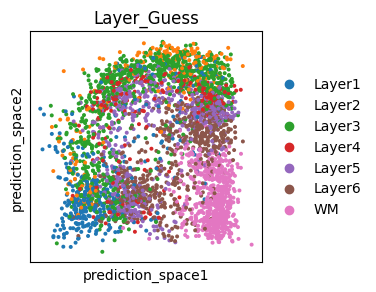

In [6]:
model_151675, criterion_151675, optimizer_151675_net = initialize_model(input_features=575, hidden_layers=[256, 128, 64], output_features=2)
train_151675_loader, val_151675_loader = prepare_data(st_151675_adata.X, spatial_151675, weights_151675)
train_and_validate(model_151675, train_151675_loader, val_151675_loader, optimizer_151675_net, criterion_151675, 500)
predictions_array_151675=predict_and_plot(model_151675, torch.tensor(sc_adata.X, dtype=torch.float32), sc_adata, 'Layer_Guess')

### Training on the second ST slice and generate predictions for scRNA-seq data

Starting
Done!


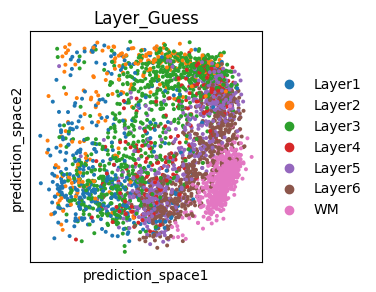

In [7]:
model_151507, criterion_151507, optimizer_151507_net = initialize_model(input_features=575, hidden_layers=[256, 128, 64], output_features=2)
train_151507_loader, val_151507_loader = prepare_data(st_151507_adata.X, spatial_151507, weights_151507)
train_and_validate(model_151507, train_151507_loader, val_151507_loader, optimizer_151507_net, criterion_151507, 500)
predictions_array_151507 = predict_and_plot(model_151507, torch.tensor(sc_adata.X, dtype=torch.float32), sc_adata,'Layer_Guess')

### Training on the third ST slice and generate predictions for scRNA-seq data

Starting
Done!


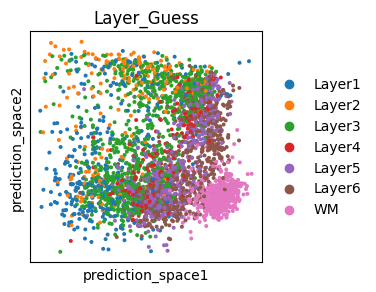

In [8]:
model_151508, criterion_151508, optimizer_151508_net = initialize_model(input_features=575, hidden_layers=[256, 128, 64], output_features=2)
train_151508_loader, val_151508_loader = prepare_data(st_151508_adata.X, spatial_151508, weights_151508)
train_and_validate(model_151508, train_151508_loader, val_151508_loader, optimizer_151508_net, criterion_151508, 500)
predictions_array_151508 = predict_and_plot(model_151508, torch.tensor(sc_adata.X, dtype=torch.float32), sc_adata,'Layer_Guess')

## 4. Estimation of the slice-specific weight

In [9]:
beta_values = optimize_prediction_weights(sc_adata, predictions_array_151675, predictions_array_151507, predictions_array_151508)

## 5. Comprehensive training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(input_features=575, hidden_layers=[256, 128, 64], output_features=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)
EPOCHS = 3000

train_model(
    model, 
    optimizer, 
    EPOCHS, 
    [st_151675_adata, st_151507_adata, st_151508_adata],  
    [spatial_151675, spatial_151507, spatial_151508],   
    [weights_151675, weights_151507, weights_151508],    
    beta_values                              
)

Done!


## 6. Predicting

In [11]:
model.eval()
test_data = torch.tensor(sc_adata.X, dtype=torch.float32).to(device)
with torch.no_grad(): 
    predictions = model(test_data)
sc_adata.obsm['prediction_space'] = np.array(predictions.cpu())

## 7.Visualization

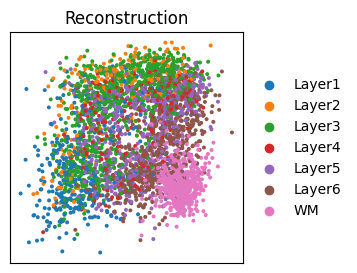

In [12]:
plt.rcParams["figure.figsize"] = (3, 3)
ax = sc.pl.embedding(sc_adata, basis='prediction_space', color='Layer_Guess', title='Reconstruction', show=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()